In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import pmdarima as pm


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LeakyReLU

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


data_file = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [2]:
df_ru = data_file.parse(0)
df_tur = data_file.parse(1)
df_eg = data_file.parse(2)
df_bra = data_file.parse(3)
df_arg = data_file.parse(4)
df_col = data_file.parse(5)
df_sa = data_file.parse(6)
df_sk = data_file.parse(7)

In [3]:
df_arg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      301 non-null    object 
 1   Price     301 non-null    object 
 2   Open      301 non-null    object 
 3   High      301 non-null    object 
 4   Low       301 non-null    object 
 5   Vol.      300 non-null    object 
 6   Change %  300 non-null    float64
dtypes: float64(1), object(6)
memory usage: 16.6+ KB


In [4]:
def timeseries_preprocessing(df):
    #Drop the last row of the dataframe
    df.drop([df.shape[0]-1], axis=0, inplace=True)
    
    # Search if there is K instead of M in volume colum
    k_data = df[df['Vol.'].astype(str).str.contains('K')]
    df = df[df["Vol."].str.contains("K") == False]
    
    #replace with K with nothing and change it to numeric value
    k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
    k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
    
    # convert it to M by dividing it by 1000
    k_data['Vol.'] = [(i/1000) for i in k_data['Vol.']]
    
    #join the two dataframe
    df = pd.concat([df, k_data], join="inner")
    
    # remove the (M) and (-) characters
    df['Vol.'] = df['Vol.'].str.replace('M', '').replace('-', '')
    
    # fix the Date column data type to be in a date format instead of object
    df[["Date"]] = df[["Date"]].apply(pd.to_datetime)
    
    # change the Price and other columns data type to int
    df[["Price", "Open", "High", "Low", "Change %", 'Vol.']] = df[["Price", "Open", "High", "Low", "Change %", 'Vol.']].apply(pd.to_numeric)
    
    # make the index equal to Date values
    df = df.sort_values(by=['Date'], ascending=True)  
    
    df = df.drop(columns =['Vol.','Change %'])

    return df

# Argentina - Pampa Energia SA

In [5]:
df = timeseries_preprocessing(df_arg)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 299 to 0
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    300 non-null    datetime64[ns]
 1   Price   300 non-null    float64       
 2   Open    300 non-null    float64       
 3   High    300 non-null    float64       
 4   Low     300 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 14.1 KB


<ipython-input-4-f3766a7b7a0d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
<ipython-input-4-f3766a7b7a0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
<ipython-input-4-f3766a7b7a0d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [6]:
def timeseries_plot(df):
    indexed_dataset = df.set_index('Date')
    indexed_dataset[['Price','Open','High','Low']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Values($)',fontsize=20);
    plt.title('Timeseries Plot of High, Low, Open, Closing Price of Stocks',fontsize = 20)
    plt.show() 

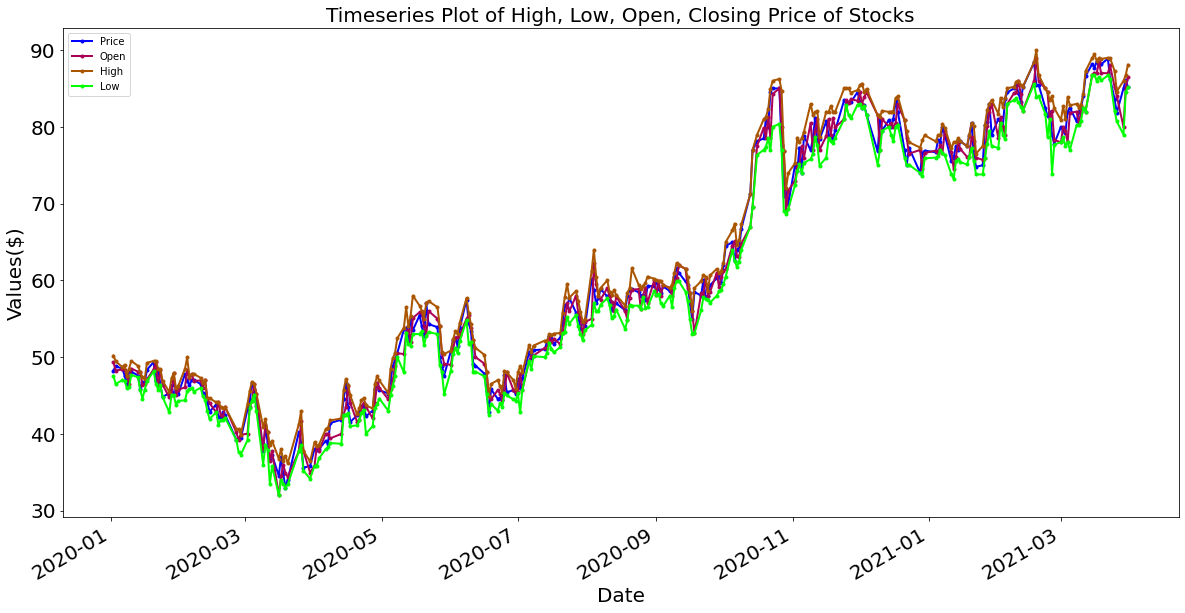

In [7]:
timeseries_plot(df)

In [8]:
def timeseries_plot_closing_value(df):
    
    indexed_dataset = df.set_index('Date')
    indexed_dataset['Price'].plot(figsize=(12,5))
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Closing Value($)',fontsize=20);
    plt.title('Timeseries of closing stock Price',fontsize = 20)
    plt.show()
    

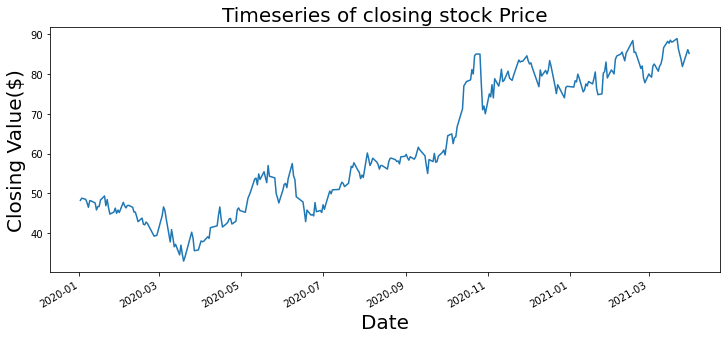

In [9]:
timeseries_plot_closing_value(df)

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def acf_pacf_plot(df):
    indexed_dataset = df.set_index('Date')
    df_close= indexed_dataset['Price']
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df_close,lags=20,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(df_close,lags=20,ax=ax2)


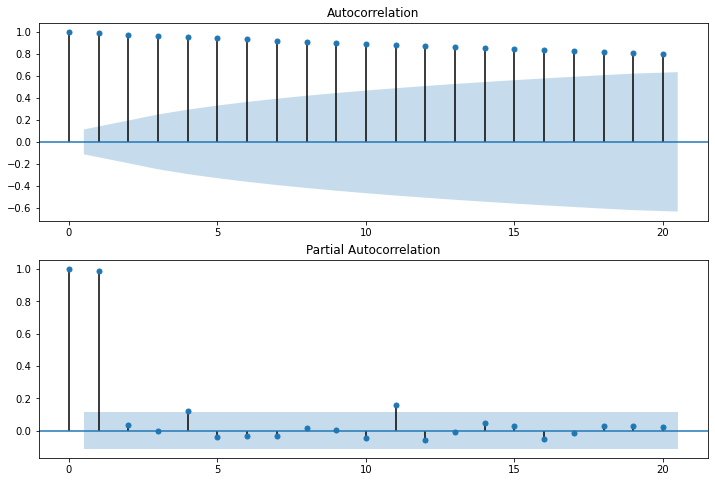

In [11]:
acf_pacf_plot(df)

In [12]:
def stationary(df):
    result = adfuller(df.Price.values, autolag='AIC')
    if result[1] > 0.05:
        print(f'The p-value is {result[1]} reject the null hypthesis and data is not stationary')
        result = adfuller(np.diff(df.Price.values), autolag='AIC')
    if result[1] < 0.05:
        print(f'The p-value after first difference is {result[1]}, accept the null hypothesis and data is stationary')
        difference = df.Price.diff()
        df['Difference'] = difference
    else:
        print('Your time series is not stationary, you may need to make another difference')
    return df

In [13]:
df = stationary(df)

The p-value is 0.8357469289607862 reject the null hypthesis and data is not stationary
The p-value after first difference is 2.2378052806172923e-30, accept the null hypothesis and data is stationary


In [14]:
df = df.dropna()
df

,Date,Price,Open,High,Low,Difference
298,2020-01-03,48.80,48.25,49.45,46.50,0.55
297,2020-01-06,48.50,48.40,48.70,47.00,-0.30
296,2020-01-07,47.60,48.35,49.00,46.90,-0.90
295,2020-01-08,46.50,47.50,47.50,46.00,-1.10
294,2020-01-09,48.20,46.55,48.50,46.05,1.70
...,...,...,...,...,...,...
4,2021-03-25,83.60,85.20,87.30,82.10,-2.70
3,2021-03-26,81.85,84.00,84.60,80.70,-1.75
2,2021-03-29,85.00,80.00,86.00,79.00,3.15
1,2021-03-30,86.10,85.15,86.75,84.60,1.10


In [15]:
df['Price'] = df['Difference']

In [16]:
df_close = df.set_index('Date')

In [17]:
df_close = df['Price']

In [18]:
df_close

298    0.55
297   -0.30
296   -0.90
295   -1.10
294    1.70
       ... 
4     -2.70
3     -1.75
2      3.15
1      1.10
0     -0.95
Name: Price, Length: 299, dtype: float64

In [19]:
df_close

298    0.55
297   -0.30
296   -0.90
295   -1.10
294    1.70
       ... 
4     -2.70
3     -1.75
2      3.15
1      1.10
0     -0.95
Name: Price, Length: 299, dtype: float64

In [20]:
X = df_close
train, test = X[0:-30], X[-30:]

In [21]:
train.shape

(269,)

In [22]:
test.shape

(30,)

In [23]:
def actual_prediction_plot(actual, prediction):
    plt.figure(figsize=(16, 5))
    plt.plot(actual, label='Actual', linewidth=1.5)
    plt.plot(prediction, label='Predictions', linewidth=1.5)
    plt.title('Actual  VS. Predicted Price', fontsize=20)
    plt.legend();

In [24]:
 arima_model = pm.auto_arima(train, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [25]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  269
Model:                        SARIMAX   Log Likelihood                -577.542
Date:                Mon, 23 May 2022   AIC                           1157.084
Time:                        11:06:46   BIC                           1160.679
Sample:                             0   HQIC                          1158.528
                                - 269                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.2893      0.299     14.331      0.000       3.703       4.876
Ljung-Box (Q):                       35.65   Jarque-Bera (JB):                13.21
Prob(Q):                              0.67   Pr

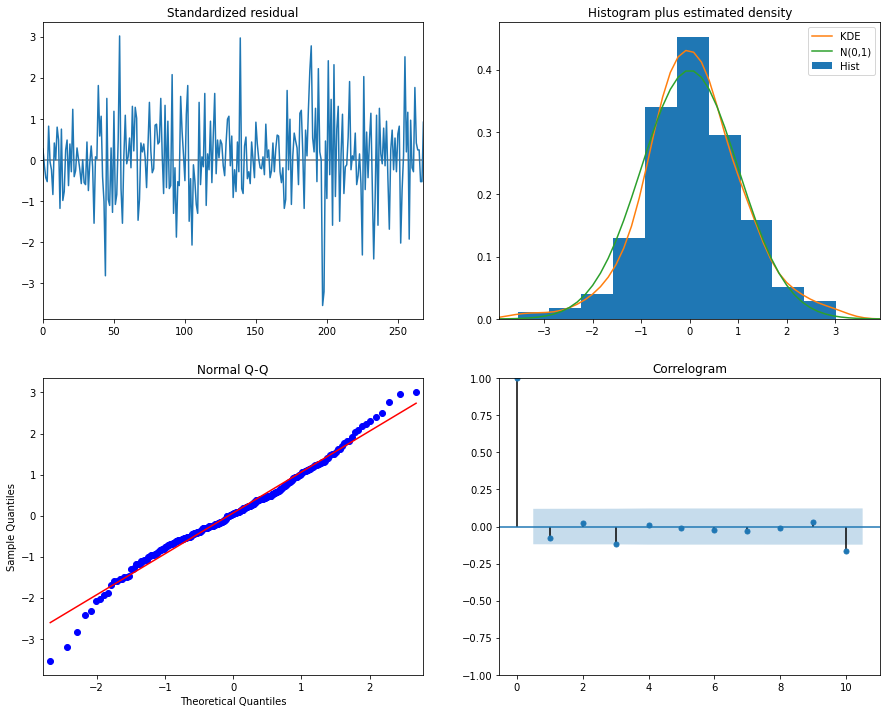

In [26]:
arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [27]:
y_pred = arima_model.predict(len(test))

In [28]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

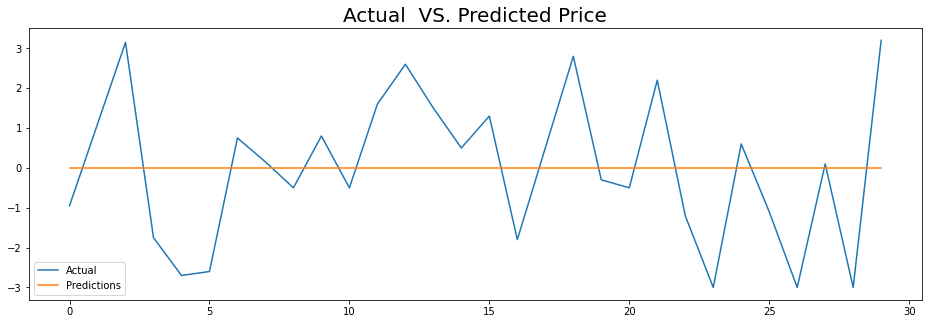

In [29]:
actual_prediction_plot(test, y_pred)

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [31]:
 mean_absolute_error(test, y_pred)

1.5249999999999995

In [32]:
# 1) create the model
sarima_model = pm.auto_arima(train, start_p=1, start_q=1, test='adf', max_p=6, max_q=6,
                             m=1, d=None, seasonal=True, start_P=0, D=1, trace=False, error_action='ignore',
                             suppress_warnings=True, stepwise=False)   

In [33]:
y_pred = sarima_model.predict(len(test))

In [34]:
mean_absolute_error(test, y_pred)

1.5183333333333333

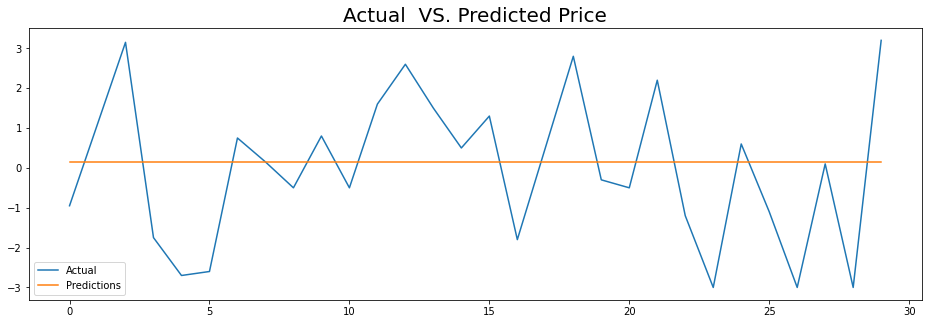

In [35]:
actual_prediction_plot(test, y_pred)

# LSTM Model

In [36]:
df = timeseries_preprocessing(df_arg)

<ipython-input-4-f3766a7b7a0d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
<ipython-input-4-f3766a7b7a0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
<ipython-input-4-f3766a7b7a0d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [37]:
df

,Date,Price,Open,High,Low
298,2020-01-03,48.80,48.25,49.45,46.50
297,2020-01-06,48.50,48.40,48.70,47.00
296,2020-01-07,47.60,48.35,49.00,46.90
295,2020-01-08,46.50,47.50,47.50,46.00
294,2020-01-09,48.20,46.55,48.50,46.05
...,...,...,...,...,...
4,2021-03-25,83.60,85.20,87.30,82.10
3,2021-03-26,81.85,84.00,84.60,80.70
2,2021-03-29,85.00,80.00,86.00,79.00
1,2021-03-30,86.10,85.15,86.75,84.60


In [38]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [39]:
train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes

In [40]:
train_test_boundary

60

In [41]:
date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

In [42]:
df = df.set_index('Date')

In [43]:
df

,Price,Open,High,Low,Year
Date,,,,,
2020-01-03,48.80,48.25,49.45,46.50,2020
2020-01-06,48.50,48.40,48.70,47.00,2020
2020-01-07,47.60,48.35,49.00,46.90,2020
2020-01-08,46.50,47.50,47.50,46.00,2020
2020-01-09,48.20,46.55,48.50,46.05,2020
...,...,...,...,...,...
2021-03-25,83.60,85.20,87.30,82.10,2021
2021-03-26,81.85,84.00,84.60,80.70,2021
2021-03-29,85.00,80.00,86.00,79.00,2021


In [44]:
#removing the Year column
df = df.drop(columns = ['Year'])

In [45]:
#global variables
n_steps = 3
n_features = 1


In [46]:
#normalize the data
scaler = MinMaxScaler()
cols = df.columns
df[cols] = scaler.fit_transform(df[cols])

In [47]:
#defining the training dataframe
train_df = df[:train_test_boundary]
    
#defining the testing dataframe
test_df = df[train_test_boundary:]

In [48]:
train_df.shape

(60, 4)

In [49]:
test_df.shape

(239, 4)

In [50]:
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x_price = data['Price'].iloc[i:end_ix]
        seq_y = data['Price'].iloc[end_ix]
        x = np.empty((3,n_features))
        for idx in range(n_steps):
            x[idx, 0] = seq_x_price[idx]
        y.append(seq_y)
        X.append(x)
    return np.array(X), np.array(y)

In [51]:
#creating training set and labels with a n_step of 3
X_train, y_train = split_sequence(train_df, n_steps)
    
#creating training set and labels with a n_step of 3
X_test, y_test = split_sequence(test_df, n_steps)

In [52]:
X_train.shape,y_train.shape

((57, 3, 1), (57,))

In [53]:
X_test.shape,y_test.shape

((236, 3, 1), (236,))

In [54]:
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mse'])
    
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
    
# fit model
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data = (X_test, y_test))

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [55]:
#generating the predicted array using model.predict
forecast = []
y_hat = []

for time in range (len(df) - n_steps):
    X = df['Price'].to_numpy()
    pred = model.predict(X[time:time+n_steps].reshape(1,3,1))
    forecast.append(pred)

y_hat = np.array(forecast)

y_hat = np.append(y_hat[:, 0], np.zeros((y_hat[:, 0].shape[0], 3)), axis=1) 
y_hat = scaler.inverse_transform(y_hat) #converting the normalized data back to its orginal 

df = scaler.inverse_transform(df)

df_final = pd.DataFrame()
df_final['Actual Price'], df_final['Predicted Price'], df_final["Date"] = df[3:, 0], y_hat[:, 0], date_arr[3:]
df_final = df_final.set_index('Date')

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [56]:
df_final

,Actual Price,Predicted Price
Date,,
2020-01-08,46.50,47.423212
2020-01-09,48.20,46.983816
2020-01-10,48.10,46.416777
2020-01-13,47.60,46.318049
2020-01-14,45.85,47.062392
...,...,...
2021-03-25,83.60,71.020020
2021-03-26,81.85,70.465249
2021-03-29,85.00,68.742674


In [57]:
#calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
df_final = df_final.dropna(axis=0)
rmse = sqrt(mean_squared_error(df_final['Actual Price'], df_final['Predicted Price']))
print("Root Mean Squared Error is", rmse)

df_final_copy = df_final

Root Mean Squared Error is 9.882277442587576


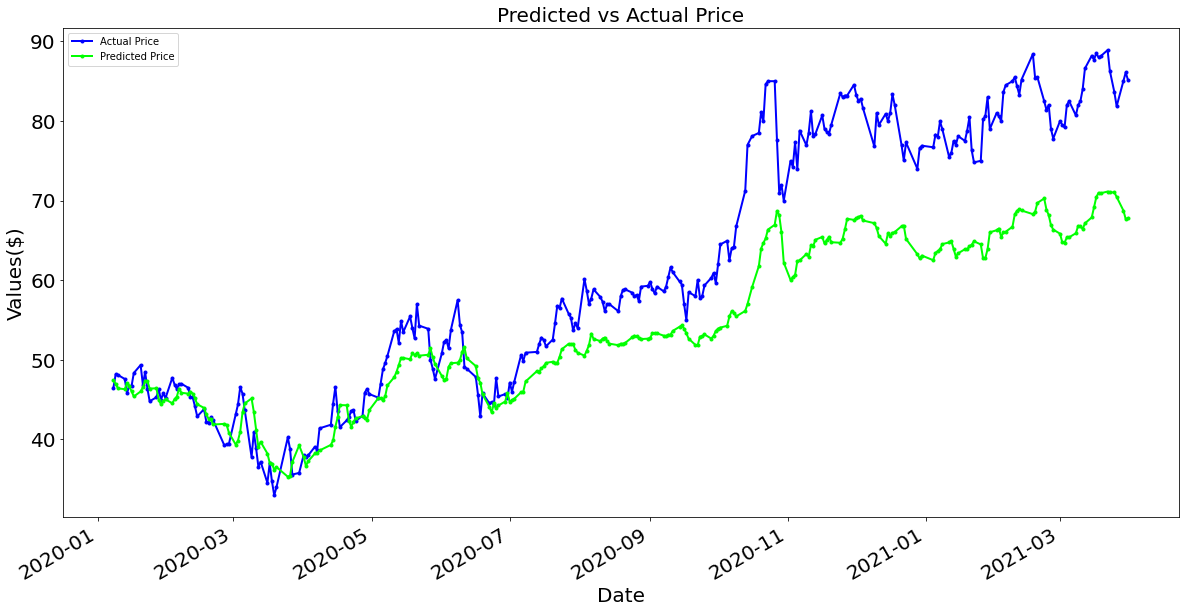

In [58]:
df_final[['Actual Price','Predicted Price']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
plt.xlabel('Date',fontsize=20);
plt.ylabel('Values($)',fontsize=20);
plt.title('Predicted vs Actual Price',fontsize = 20)
plt.show() 

<Figure size 432x288 with 0 Axes>

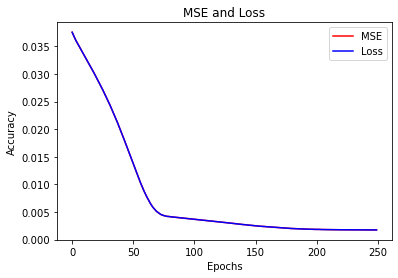

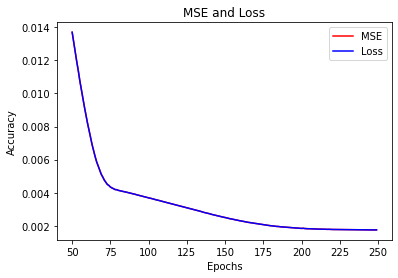

<Figure size 432x288 with 0 Axes>

In [59]:
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mse_zoom = mse[50:]
loss_zoom = loss[50:]

plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()


In [60]:
#bollinger bands calculation
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1, len(data)):
        if data.iloc[i-1] > lower_bb.iloc[i-1] and data.iloc[i] < lower_bb.iloc[i]:
            if signal != 1:
                buy_price.append(data.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data.iloc[i-1] < upper_bb.iloc[i-1] and data.iloc[i] > upper_bb.iloc[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data.iloc[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [61]:
investment_returns = []
sma_params = []
bb_params = []
        
for sma_param in np.linspace(10, 100, 10).astype(int):
    df_final = df_final_copy
    df_final['sma_20'] = sma(df_final['Predicted Price'], sma_param)
    for bb_param in np.linspace(10, 100, 10).astype(int):
        df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma_20'], bb_param)
        buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
        buy_price.insert(0, None)
        sell_price.insert(0, None)
        bb_signal.insert(0, None)

        position = []
        for i in range(len(bb_signal)):
            if bb_signal[i] == None:
                position.append(None)
                continue
            if bb_signal[i] > 1:
                position.append(0)
            else:
                position.append(1)

        for i in range(len(df_final['Predicted Price'])):
            if bb_signal[i] == None:
                continue
            if bb_signal[i] == 1:
                position[i] = 1
            elif bb_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1]

        upper_bb = df_final['upper_bb']
        lower_bb = df_final['lower_bb']
        close_price = df_final['Predicted Price']
        bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df_final.index)
        position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df_final.index)

        frames = [close_price, upper_bb, lower_bb, bb_signal, position]
        strategy = pd.concat(frames, join = 'inner', axis = 1)
        
        #backtesting on actual price
        price_diff = np.diff(df_final['Actual Price'])
        list(price_diff).insert(0, None)
        df_final_ret = pd.DataFrame(price_diff).rename(columns = {0:'returns'})
        bb_strategy_ret = []

        for i in range(len(df_final_ret)):
            try:
                returns = df_final_ret['returns'][i]*strategy['bb_position'][i]
                bb_strategy_ret.append(returns)
            except:
                bb_strategy_ret.append(np.nan)

        bb_strategy_ret.insert(0, None)
        bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
        bb_strategy_ret_df

        investment = 100000
        stocks = 0

        for i in range(len(bb_strategy_ret_df['bb_returns'])):
            if strategy['bb_signal'].iloc[i] == None:
                continue
            if strategy['bb_signal'].iloc[i] == 1:
                stocks = int(investment/df_final['Actual Price'].iloc[i])
            returns = stocks * bb_strategy_ret_df['bb_returns'].iloc[i]
            if str(returns) != 'nan':
                investment = investment + returns
        investment_returns.append(investment - 100000)
        sma_params.append(sma_param)
        bb_params.append(bb_param)
        
max_idx = np.argmax(np.array(investment_returns))
print("Highest return is ${} with sma of {} using a bollinger parameter {}". 
      format(investment_returns[max_idx], sma_params[max_idx], bb_params[max_idx]))

Highest return is $92790.69999999998 with sma of 30 using a bollinger parameter 30


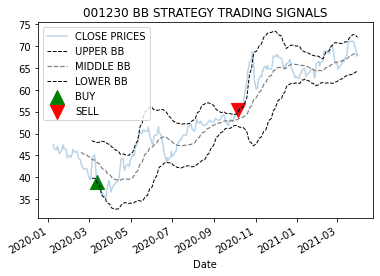

In [62]:
df_final['sma'] = sma(df_final['Predicted Price'], 30)
df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], 40)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
buy_price.insert(0, None)
sell_price.insert(0, None)
bb_signal.insert(0, None)

df_final['Predicted Price'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df_final['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df_final['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df_final['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df_final.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df_final.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('001230 BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()